In [1]:
import itertools
import glob
import os
import sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from joblib import Parallel, delayed

/home/dev/anaconda3/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [177]:
IS_ILLUSTRATED = True
if IS_ILLUSTRATED:
    %matplotlib inline
    import pandas as pd
    import seaborn as sns
    sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [3]:
import cofacto
import rec_eval
import cofacto_util as util

/home/dev/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [239]:
import imp

In [186]:
### 

In [88]:
DATA_DIR = '../data/'
DATA_SET_NAME = 'UIDSID'
FN_UID_SIDS = 'uid_sids.txt'

In [110]:
idx2uid, uid2idx, idx2sid, sid2idx = util.make_index(os.path.join(DATA_DIR, FN_UID_SIDS))

In [111]:
uid_sids_dict = util.make_uid_sids_dict(os.path.join(DATA_DIR, FN_UID_SIDS))

In [187]:
### preprocess

In [197]:
import cofacto_preprocess as preprocessor
preprocessor = imp.reload(preprocessor)

../data/data_train.txt ../data/data_dev.txt ../data/data_test.txt
n_users:31677
n_items:63153
The mean (median) watches per item is 4 (1)
The mean (median) items each user wathced is 8 (4)
Genereting coord batched from 0 to 5000
Genereting coord batched from 5000 to 10000
Genereting coord batched from 10000 to 15000
Genereting coord batched from 15000 to 20000
Genereting coord batched from 20000 to 25000
Genereting coord batched from 25000 to 30000
Genereting coord batched from 30000 to 31677
Users 0 to 5000 finished
Users 5000 to 10000 finished
Users 10000 to 15000 finished
Users 15000 to 20000 finished
Users 20000 to 25000 finished
Users 25000 to 30000 finished
Users 30000 to 31677 finished
co-occurrence matrix X sparcity:0.0011946388979649958


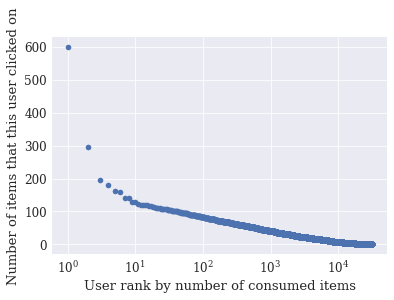

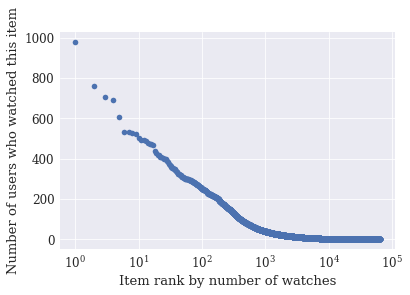

In [185]:
preprocessor.preprocess()

In [26]:
### load the pre-saved co-occurrence matrix

In [195]:
X = preprocessor.load_co_matrix()

n_users:31677
n_items:63153
co-occurrence matrix sparcity:0.0011946388979649958


In [202]:
### compute SPPMI matrix

PPMI matrix M sparcity:0.0011441136293518282
SPPMI matrix M_ns sparcity:0.0011441136293518282


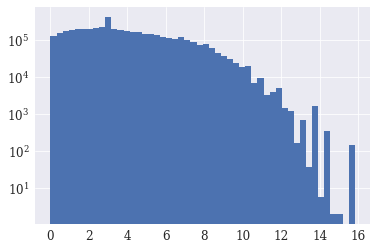

In [200]:
M_ns = preprocessor.make_sppmi_matrix(X, k_ns=1)

In [ ]:
### train

In [214]:
import cofacto_train as trainer

In [215]:
trainer.train(M_ns)

n_users:31677
n_items:63153
ITERATION #0
	Updating user factors: time=10.73
	Updating item factors: time=24.98
	Updating context factors: time=25.17
	Updating bias terms: time=5.04


/home/dev/repo/cofacto/src/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


	Validation NDCG@k: 0.00000
ITERATION #1
	Updating user factors: time=10.37
	Updating item factors: time=26.44
	Updating context factors: time=25.19
	Updating bias terms: time=5.06
	Validation NDCG@k: 0.00000
ITERATION #2
	Updating user factors: time=10.10
	Updating item factors: time=25.74
	Updating context factors: time=25.27
	Updating bias terms: time=5.07
	Validation NDCG@k: 0.00000
ITERATION #3
	Updating user factors: time=10.80
	Updating item factors: time=26.43
	Updating context factors: time=24.97
	Updating bias terms: time=5.11
	Validation NDCG@k: 0.00000
ITERATION #4
	Updating user factors: time=10.73
	Updating item factors: time=26.05
	Updating context factors: time=24.67
	Updating bias terms: time=5.82
	Validation NDCG@k: 0.00000
ITERATION #5
	Updating user factors: time=10.54
	Updating item factors: time=26.21
	Updating context factors: time=26.33
	Updating bias terms: time=5.93
	Validation NDCG@k: 0.00000
ITERATION #6
	Updating user factors: time=11.58
	Updating item fact

/home/dev/repo/cofacto/src/rec_eval.py:184: RuntimeWarning: invalid value encountered in true_divide
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))


Test Recall@20: 0.2054
Test Recall@50: 0.2760
Test NDCG@100: 0.1647
Test MAP@100: 0.0913
saved


In [216]:
### predict

In [217]:
import cofacto_predict as predictor
predictor = imp.reload(predictor)
U, V = predictor.load_model()

In [224]:
uid = '86361091'

In [225]:
his_scores, his_sids = predictor.uid_history_scores(uid, U, V)

In [232]:
topk_sids, topk_scores = predictor.topk_for_uid(uid, U, V, sid_prefix=None, topk=20)

In [233]:
recom_sids, inter_sids = predictor.difference_and_intersection(uid, topk_sids)

In [234]:
his_sids

['M1180804765',
 'M1023606622',
 'M1001259112',
 'M1258952238',
 'M1009424927',
 'M1021574770',
 'M1283988466',
 'M1377364526',
 'M1328615355',
 'M993203707']

In [237]:
recom_sids

['M1217331891',
 'M1017418700',
 'M1089690697',
 'M1092108481',
 'M1134218233',
 'M1055706684',
 'M1087883560',
 'M1125508961',
 'M1159063112',
 'M1303198095',
 'M1239130371',
 'M1001165755',
 'M964466133',
 'M1292881217']

In [238]:
inter_sids

['M1180804765',
 'M1001259112',
 'M1258952238',
 'M1021574770',
 'M1283988466',
 'M1377364526']